# Ferechet Inception Distance

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from icecream import ic
import cv2


import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from skimage.metrics import structural_similarity as ssim

from PIL import Image
import pandas as pd

from scipy.stats import entropy

from torch import nn, optim

from torchmetrics.image.inception import InceptionScore


e:\Programe\Anaconda\envs\Pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CGAN 64x64
- 15 epoci
- 30 epoci

In [7]:
## MODELS ##
from Models.CGAN_64x64.dataset import DatasetCelebA
from Models.CGAN_64x64.discriminator_test import Discriminator
from Models.CGAN_64x64.generator_test import Generator

def generate_images(base_path='E:\Lucru\Dizertatie\Cod\EvaluatingPerformance\Pretrained\CGAN_64x64\\15epoci', 
                    attribut=0, img_size=64, display=0, numberOfSamples = 1):
# Dimensiunea vectorului latent
    dim_zgomot = 100

    retea_G = Generator(dim_zgomot=dim_zgomot, img_size=img_size)
    retea_D = Discriminator(img_size=img_size)


    retea_G.load_state_dict(torch.load(base_path + '\\retea_Generator.pt'))
    retea_D.load_state_dict(torch.load(base_path + '\\retea_Discriminator.pt'))

    # retea_G.load_state_dict(torch.load('E:\Lucru\Dizertatie\Cod\ConditionalGAN_onlyGender\\10epoci\\retea_Generator.pt'))
    # retea_D.load_state_dict(torch.load('E:\Lucru\Dizertatie\Cod\ConditionalGAN_onlyGender\\10epoci\\retea_Discriminator.pt'))

    retea_G.cuda()
    retea_D.cuda()

    retea_G.eval()
    retea_D.eval()
    # esantioane_proba = torch.randn(1, dim_zgomot, 1, 1)
    # etichete_proba = torch.LongTensor([0])
    if numberOfSamples > 1:
        esantioane_proba = torch.randn(numberOfSamples, dim_zgomot, 1, 1)
        etichete_proba1 = torch.FloatTensor([[attribut]])
        etichete_proba = etichete_proba1.repeat(numberOfSamples, 1)
    else:
        esantioane_proba = torch.randn(numberOfSamples, dim_zgomot, 1, 1)
        etichete_proba = torch.FloatTensor([[attribut]])

    etichete_proba = etichete_proba.to(torch.device('cuda'))
    esantioane_proba = esantioane_proba.to(torch.device('cuda'))

    imagini_generate = retea_G(esantioane_proba, etichete_proba).detach()
    imagini_generate = torch.squeeze(imagini_generate, 0)
    imagini_generate = imagini_generate.to(torch.device('cpu'))

    if numberOfSamples > 1:
        return imagini_generate
    
    # plt.figure()
    # plt.title("Imagini generate")
    # plt.imshow(np.transpose(imagini_generate,(1,2,0)))
    # plt.show()
    if display == 1:
        plt.figure()
        plt.imshow(np.transpose(imagini_generate,(1,2,0)))
        plt.show()

    return np.transpose(imagini_generate,(1,2,0))


# generate_images(display=0, numberOfSamples=2)


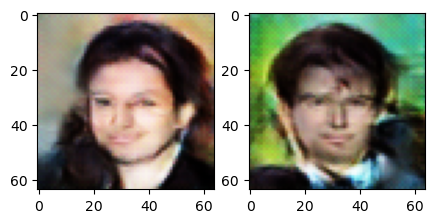

In [4]:
path1='E:\Lucru\Dizertatie\Cod\EvaluatingPerformance\Pretrained\CGAN_64x64\\15epoci'
path2='E:\Lucru\Dizertatie\Cod\EvaluatingPerformance\Pretrained\CGAN_64x64\\40epoci'

img_1 = generate_images(base_path=path1, attribut=0)
plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(img_1)
img_2 = generate_images(base_path=path1, attribut=1)
plt.subplot(1,2,2)
plt.imshow(img_2)
plt.show()

# generated_images = torch.stack([img_1, img_2], dim=0)
# inception = InceptionScore(normalize=True)



In [25]:
path1='E:\Lucru\Dizertatie\Cod\EvaluatingPerformance\Pretrained\CGAN_64x64\\15epoci'
path2='E:\Lucru\Dizertatie\Cod\EvaluatingPerformance\Pretrained\CGAN_64x64\\40epoci'

images1 = generate_images(base_path=path2, attribut=1, numberOfSamples=100)
images2 = generate_images(base_path=path2, attribut=0, numberOfSamples=100)

# ic(more_images.shape)
inception = InceptionScore(normalize=True)

inception.update(images1)
score, std = inception.compute()
print(f"Inception score: {score}")

inception = InceptionScore(normalize=True)
inception.update(images2)
score, std = inception.compute()
print(f"Inception score: {score}")



Inception score: 1.0148236751556396
Inception score: 1.0049710273742676


In [41]:
from torchmetrics.image.fid import FrechetInceptionDistance
EXCEL_PATH = "E:\Lucru\Dizertatie\Cod\Face_Synthesis\Database\celebA_medium.xlsx"
DATASET_PATH = "E:\Lucru\Dizertatie\Baze de date\CelebA_crop\CelebA_Crop_medium\\"

path1='E:\Lucru\Dizertatie\Cod\EvaluatingPerformance\Pretrained\CGAN_64x64\\15epoci'
path2='E:\Lucru\Dizertatie\Cod\EvaluatingPerformance\Pretrained\CGAN_64x64\\40epoci'
numberOfSamples = 100

synth_images = generate_images(base_path=path1, attribut=0, numberOfSamples=numberOfSamples)
# images2 = generate_images(base_path=path2, attribut=0, numberOfSamples=100)

fid = FrechetInceptionDistance(feature=64, normalize=True)

random_images = torch.randn(numberOfSamples, 3, 64, 64)

dataset = DatasetCelebA(base_path=DATASET_PATH, excel_path=EXCEL_PATH)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

extracted_images = []
extracted_images2 = []


for i, (image, _) in enumerate(dataloader):
    if i < 100:
        extracted_images.append(image)
    else:
        extracted_images2.append(image)

    if i + 1 == 200:
        break

extracted_images = torch.cat(extracted_images, dim=0)
extracted_images2 = torch.cat(extracted_images2, dim=0)


ic(extracted_images.shape)
ic(extracted_images2.shape)

fid.update(extracted_images, real=True)
fid.update(random_images, real=False)
fid.compute()

ic| extracted_images.shape: torch.Size([100, 3, 64, 64])
ic| extracted_images2.shape: torch.Size([100, 3, 64, 64])


tensor(313.5763)

# CGAN-128

In [17]:
## MODELS ##
from Models.CGAN_128x128.no_crop.generator import Generator

def generate_images(base_path='E:\Lucru\Dizertatie\Cod\EvaluatingPerformance\Pretrained\CGAN_128x128\\no_crop', 
                    attribute=[0,1,0,0,0,0], img_size=128, display=0, numberOfSamples = 1):
    # Dimensiunea vectorului latent
    dim_zgomot = 100

    retea_G = Generator(dim_zgomot=dim_zgomot, img_size=img_size, attribute_number=6)
    retea_G.load_state_dict(torch.load(base_path + '\\retea_Generator.pt'))

    retea_G.cuda()
    retea_G.eval()
    for param in retea_G.parameters():
        param.requires_grad = False

    if numberOfSamples > 1:
        esantioane_proba = torch.randn(numberOfSamples, dim_zgomot, 1, 1)
        etichete_proba1 = torch.FloatTensor([attribute])
        etichete_proba = etichete_proba1.repeat(numberOfSamples, 1)
    else:
        esantioane_proba = torch.randn(numberOfSamples, dim_zgomot, 1, 1)
        etichete_proba = torch.FloatTensor([attribute])

    etichete_proba = etichete_proba.to(torch.device('cuda'))
    esantioane_proba = esantioane_proba.to(torch.device('cuda'))

    imagini_generate = retea_G(esantioane_proba, etichete_proba).detach()
    imagini_generate = torch.squeeze(imagini_generate, 0)
    imagini_generate = imagini_generate.to(torch.device('cpu'))

    if numberOfSamples > 1:
        return imagini_generate
    
    # plt.figure()
    # plt.title("Imagini generate")
    # plt.imshow(np.transpose(imagini_generate,(1,2,0)))
    # plt.show()
    if display == 1:
        plt.figure()
        plt.imshow(np.transpose(imagini_generate,(1,2,0)))
        plt.show()

    return np.transpose(imagini_generate,(1,2,0))


a = generate_images(display=0, numberOfSamples=10)
ic(a.shape)

ic| a.shape: torch.Size([10, 3, 128, 128])


torch.Size([10, 3, 128, 128])

In [22]:
images1 = generate_images(attribute=[1,1,0,0,0,0], numberOfSamples=100)
images2 = generate_images(attribute=[0,1,0,0,0,0], numberOfSamples=100)

# ic(more_images.shape)
inception = InceptionScore(normalize=True)

inception.update(images1)
score, std = inception.compute()
print(f"Inception score: {score}")

inception = InceptionScore(normalize=True)
inception.update(images2)
score, std = inception.compute()
print(f"Inception score: {score}")


e:\Programe\Anaconda\envs\Pytorch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Inception score: 1.0346653461456299
Inception score: 1.028965711593628


In [27]:
from torchmetrics.image.fid import FrechetInceptionDistance
EXCEL_PATH = "E:\Lucru\Dizertatie\Cod\Face_Synthesis\Database\celebA_medium.xlsx"
DATASET_PATH = "E:\Lucru\Dizertatie\Baze de date\CelebA_crop\CelebA_Crop_medium\\"

numberOfSamples = 100                

synth_images = generate_images(attribute=[0,1,0,0,0,0], numberOfSamples=100)
# images2 = generate_images(base_path=path2, attribut=0, numberOfSamples=100)

fid = FrechetInceptionDistance(feature=64, normalize=True)

random_images = torch.randn(numberOfSamples, 3, 64, 64)
                                     
dataset = DatasetCelebA(base_path=DATASET_PATH, excel_path=EXCEL_PATH)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

extracted_images = []

for i, (image, _) in enumerate(dataloader):
    extracted_images.append(image)
    if i + 1 == numberOfSamples:                       
        break

extracted_images = torch.cat(extracted_images, dim=0)

# ic(extracted_images.shape)
# ic(synth_images.shape)

fid.update(extracted_images, real=True)
fid.update(synth_images, real=False)
fid.compute()

tensor(2.7997)

# A2F
- 64x64

In [21]:
## MODELS ##
from Models.A2F_64x64.dataset import  DatasetCelebA_Sketch
from Models.A2F_64x64.Discriminator_Stage2 import Discriminator as Discriminator_S2
from Models.A2F_64x64.Generator_Stage2 import Generator as Generator_S2
from Models.A2F_64x64.Discriminator_Stage3 import Discriminator as Discriminator_S3
from Models.A2F_64x64.Generator_Stage3 import Generator as Generator_S3
from Models.A2F_64x64.CVAE_Encoder import Encoder
from Models.A2F_64x64.CVAE_Decoder import Decoder
DEVICE = 'cuda'

def init_models(base_path, attribute_dim=4, img_size=64):
    encoder = Encoder(attribute_number=attribute_dim)
    decoder = Decoder(attribute_number=attribute_dim)
    retea_G3 = Generator_S3(img_size=3, attribute_number=attribute_dim)
    retea_D3 = Discriminator_S3(img_size=img_size, attribute_number=attribute_dim)
    retea_G2 = Generator_S2(attribute_number=attribute_dim)
    retea_D2 = Discriminator_S2(img_size=img_size, attribute_number=attribute_dim)
    retea_G3.cuda()
    retea_D3.cuda()
    retea_G2.cuda()
    retea_D2.cuda()
    encoder.cuda()
    decoder.cuda()
    encoder.eval()
    decoder.eval()
    retea_G3.eval()
    retea_D3.eval()
    retea_G2.eval()
    retea_D2.eval()

    decoder.load_state_dict(torch.load(base_path + '\\retea_Decoder.pt'))
    encoder.load_state_dict(torch.load(base_path + '\\retea_Encoder.pt'))

    retea_D2.load_state_dict(torch.load(base_path + '\\retea_D_Stage2.pt'))
    retea_G2.load_state_dict(torch.load(base_path + '\\retea_G_Stage2.pt'))

    retea_D3.load_state_dict(torch.load(base_path + '\\A2F_retea_D_Stage3.pt'))
    retea_G3.load_state_dict(torch.load(base_path + '\\A2F_retea_G_Stage3.pt'))
    return encoder, decoder, retea_D2, retea_G2, retea_D3, retea_G3

base_path='E:\Lucru\Dizertatie\Cod\EvaluatingPerformance\Pretrained\A2F_64x64'
encoder, decoder, retea_D2, retea_G2, retea_D3, retea_G3 = init_models(base_path=base_path)
def synth_images(base_path='E:\Lucru\Dizertatie\Cod\EvaluatingPerformance\Pretrained\A2F_64x64', atribute=[0,0,0,1], img_size=64, display=0, stage=3, numberOfSamples = 1):
    # encoder, decoder, retea_D2, retea_G2, retea_D3, retea_G3 = init_models(base_path=base_path)
        
    if numberOfSamples > 1:
        esantioane_proba = torch.randn(numberOfSamples, 3, img_size, img_size)
        etichete_proba = torch.FloatTensor([atribute])
        attributes = etichete_proba.repeat(numberOfSamples, 1)
    else:
        sketch_img = torch.randn(3, img_size, img_size)
        esantioane_proba = torch.stack([sketch_img], dim=0)
        attributes = torch.FloatTensor([atribute])
        

    esantioane_proba = esantioane_proba.to(torch.device(DEVICE))
    attributes = attributes.to(torch.device(DEVICE))
    zgomot_proba = torch.FloatTensor(esantioane_proba.shape[0], 256).normal_(0, 1)
    zgomot_proba  = zgomot_proba.to(torch.device(DEVICE))

    zgomot_embedded, schita_embedded, encode_text = encoder(noise=zgomot_proba, attr_text=attributes, sketch=esantioane_proba, detach_flag=True)
    reconstructed_sketch_images, reconstructed_fake_images = decoder(zgomot_embedded[0], schita_embedded[0], detach_flag=True)

    imagini_generate_Stage2 = retea_G2(reconstructed_fake_images, encode_text).detach()
    imagini_generate_Stage3 = retea_G3(imagini_generate_Stage2, attributes).detach()

    reconstructed_sketch_images = torch.squeeze(reconstructed_fake_images, 0)
    reconstructed_sketch_images = reconstructed_sketch_images.to(torch.device('cpu'))

    reconstructed_fake_images = torch.squeeze(reconstructed_fake_images, 0)
    reconstructed_fake_images = reconstructed_fake_images.to(torch.device('cpu'))

    imagini_generate_Stage2 = torch.squeeze(imagini_generate_Stage2, 0)
    imagini_generate_Stage2 = imagini_generate_Stage2.to(torch.device('cpu'))

    imagini_generate_Stage3 = torch.squeeze(imagini_generate_Stage3, 0)
    imagini_generate_Stage3 = imagini_generate_Stage3.to(torch.device('cpu'))

    if numberOfSamples > 1:
        return imagini_generate_Stage3

    if display == 1 :
        plt.figure(figsize=(10,15))
        plt.subplot(1, 3, 1)
        plt.imshow(np.transpose(reconstructed_fake_images,(1,2,0)), cmap='gray')
        plt.title("imagini_generate_Etapa1")
        plt.subplot(1, 3, 2)
        plt.imshow(np.transpose(imagini_generate_Stage2,(1,2,0)), cmap='gray')
        plt.title("imagini_generate_Etapa2")
        plt.subplot(1, 3, 3)
        plt.imshow(np.transpose(imagini_generate_Stage3,(1,2,0)), cmap='gray')
        plt.title("imagini_generate_Etapa3")
        plt.show()
    
    if stage==3:
        return np.transpose(imagini_generate_Stage3,(1,2,0))
    
    if stage==2:
        return np.transpose(imagini_generate_Stage2,(1,2,0))
    
    if stage==1:
        return np.transpose(reconstructed_fake_images,(1,2,0))
    

a = synth_images(atribute=[0,0,0,1] ,display=1, stage=3, numberOfSamples=4)
ic(a.shape)

Using cache found in C:\Users\Teodora/.cache\torch\hub\pytorch_vision_v0.10.0
ic| a.shape: torch.Size([4, 3, 64, 64])


torch.Size([4, 3, 64, 64])

In [34]:
images1 = synth_images(atribute=[1,0,0,1] ,display=0, stage=3, numberOfSamples=100)
images2 = synth_images(atribute=[0,0,0,1] ,display=0, stage=3, numberOfSamples=100)

# ic(more_images.shape)
inception = InceptionScore(normalize=True)
inception.update(images1)
score, std = inception.compute()
print(f"Inception score: {score}")

inception = InceptionScore(normalize=True)
inception.update(images2)
score, std = inception.compute()
print(f"Inception score: {score}")

e:\Programe\Anaconda\envs\Pytorch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Inception score: 1.0106446743011475
Inception score: 1.011838674545288


In [25]:
from torchmetrics.image.fid import FrechetInceptionDistance
EXCEL_PATH = "E:\Lucru\Dizertatie\Cod\Face_Synthesis\Database\celebA_medium.xlsx"
DATASET_PATH = "E:\Lucru\Dizertatie\Baze de date\CelebA_crop\CelebA_Crop_medium\\"

numberOfSamples = 100
generated_images = synth_images(atribute=[1,0,0,1] ,display=0, stage=3, numberOfSamples=100)
# images2 = generate_images(base_path=path2, attribut=0, numberOfSamples=100)

fid = FrechetInceptionDistance(feature=64, normalize=True)

random_images = torch.randn(numberOfSamples, 3, 64, 64)

dataset = DatasetCelebA(base_path=DATASET_PATH, excel_path=EXCEL_PATH)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

extracted_images = []

for i, (image, _) in enumerate(dataloader):
    extracted_images.append(image)
    if i + 1 == numberOfSamples:
        break

extracted_images = torch.cat(extracted_images, dim=0)

ic(extracted_images.shape)
ic(generated_images.shape)

fid.update(extracted_images, real=True)
fid.update(generated_images, real=False)
fid.compute()

ic| extracted_images.shape: torch.Size([100, 3, 64, 64])
ic| generated_images.shape: torch.Size([100, 3, 64, 64])


tensor(3.8039)

# A2F-sketch

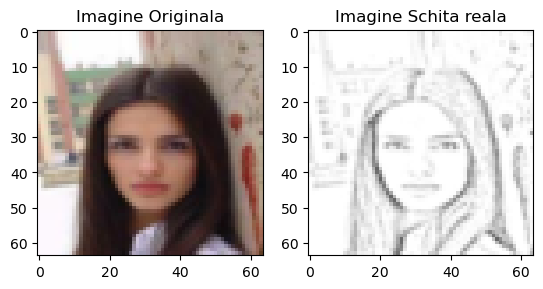

In [2]:
ATTR_DIM = 4
resize =  transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize([64,64])])

def read_images(index, display=1):
    EXCEL_PATH = "E:\Lucru\Dizertatie\Cod\Face_Synthesis\Database\celebA_medium.xlsx"
    DATASET_PATH = "E:\Lucru\Dizertatie\Cod\Face_Synthesis\Database\medium_dataset\\"
    SKETCH_DATASET_PATH = "E:\Lucru\Dizertatie\Cod\Face_Synthesis\Database\medium_dataset_sketch\\"

    resize =  transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize([64,64])])

    transf = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize([64,64]),
                                transforms.ToTensor()])

    transf_sketch = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize([64,64]),
                                transforms.ToTensor()])

    df = pd.read_excel(EXCEL_PATH)
    data = df["image_id"]
    labels = df.iloc[:, 1:(ATTR_DIM + 1)]
    # labels = df["Male"]

    # index = 17

    # 25 - nice female
    # 31 - male

    img = cv2.imread(DATASET_PATH + data[index])
    # img = cv2.imread('E:\Lucru\Dizertatie\Cod\Image-to-Sketch\source\\Vaman_Teodora.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    sketch_img = cv2.imread(SKETCH_DATASET_PATH + data[index])
    # sketch_img = cv2.imread('E:\Lucru\Dizertatie\Cod\Image-to-Sketch\destination\\Vaman_Teodora.jpg')
    sketch_img = cv2.cvtColor(sketch_img, cv2.COLOR_BGR2RGB)

    batch_data = img
    batch_data = transf(batch_data)

    batch_sketch_data = sketch_img
    batch_sketch_data = transf_sketch(batch_sketch_data)

    batch_labels = labels.iloc[index].values
    pil_img = resize(img)
    pil_img_sketch = resize(sketch_img)
    if display == 1 :
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.title("Imagine Originala")
        plt.imshow(np.asarray(pil_img))
        plt.subplot(1, 2, 2)
        plt.imshow(np.asarray(pil_img_sketch))
        plt.title("Imagine Schita reala")

    # print(f"Attributes [Gender Smiling Eyeglasses No_Beard] = {labels.iloc[index].values}")
    # Gender Smiling Eyeglasses No_Beard
    return batch_sketch_data, batch_data, batch_labels, np.asarray(pil_img)

sketch_img, img, labels, show_img = read_images(25)

In [11]:
## MODELS ##
from Models.A2F_64x64.dataset import  DatasetCelebA_Sketch
from Models.A2F_64x64.Discriminator_Stage2 import Discriminator as Discriminator_S2
from Models.A2F_64x64.Generator_Stage2 import Generator as Generator_S2
from Models.A2F_64x64.Discriminator_Stage3 import Discriminator as Discriminator_S3
from Models.A2F_64x64.Generator_Stage3 import Generator as Generator_S3
from Models.A2F_64x64.CVAE_Encoder import Encoder
from Models.A2F_64x64.CVAE_Decoder import Decoder
DEVICE = 'cuda'

def init_models(base_path, attribute_dim=4, img_size=64):
    encoder = Encoder(attribute_number=attribute_dim)
    decoder = Decoder(attribute_number=attribute_dim)
    retea_G3 = Generator_S3(img_size=3, attribute_number=attribute_dim)
    retea_D3 = Discriminator_S3(img_size=img_size, attribute_number=attribute_dim)
    retea_G2 = Generator_S2(attribute_number=attribute_dim)
    retea_D2 = Discriminator_S2(img_size=img_size, attribute_number=attribute_dim)
    retea_G3.cuda()
    retea_D3.cuda()
    retea_G2.cuda()
    retea_D2.cuda()
    encoder.cuda()
    decoder.cuda()
    encoder.eval()
    decoder.eval()
    retea_G3.eval()
    retea_D3.eval()
    retea_G2.eval()
    retea_D2.eval()

    decoder.load_state_dict(torch.load(base_path + '\\retea_Decoder.pt'))
    encoder.load_state_dict(torch.load(base_path + '\\retea_Encoder.pt'))

    retea_D2.load_state_dict(torch.load(base_path + '\\retea_D_Stage2.pt'))
    retea_G2.load_state_dict(torch.load(base_path + '\\retea_G_Stage2.pt'))

    retea_D3.load_state_dict(torch.load(base_path + '\\A2F_retea_D_Stage3.pt'))
    retea_G3.load_state_dict(torch.load(base_path + '\\A2F_retea_G_Stage3.pt'))
    return encoder, decoder, retea_D2, retea_G2, retea_D3, retea_G3

base_path='E:\Lucru\Dizertatie\Cod\EvaluatingPerformance\Pretrained\A2F_64x64'
encoder, decoder, retea_D2, retea_G2, retea_D3, retea_G3 = init_models(base_path=base_path)

def synth_images(base_path='E:\Lucru\Dizertatie\Cod\EvaluatingPerformance\Pretrained\A2F_sketch', atribute=[0,0,0,1], img_size=64, display=0, stage=3, numberOfSamples = 1):
    # encoder, decoder, retea_D2, retea_G2, retea_D3, retea_G3 = init_models(base_path=base_path)
        
    if numberOfSamples > 1:
        sketch_images = []
        for _ in range(numberOfSamples):
            random_index = random.randint(0, 80000)
            # random_index = 170
            sketch_img, _, _, _ = read_images(index=random_index, display=0)
            sketch_images.append(sketch_img)

        esantioane_proba = torch.stack(sketch_images)
        etichete_proba = torch.FloatTensor([atribute])
        attributes = etichete_proba.repeat(numberOfSamples, 1)
    else:
        random_index = random.randint(0, 80000)
        # random_index = 170

        sketch_img, img, labels, show_img = read_images(index=random_index, display=0)
        esantioane_proba = torch.stack([sketch_img], dim=0)
        attributes = torch.FloatTensor([atribute])
    

    esantioane_proba = esantioane_proba.to(torch.device(DEVICE))
    attributes = attributes.to(torch.device(DEVICE))
    zgomot_proba = torch.FloatTensor(esantioane_proba.shape[0], 256).normal_(0, 1)
    zgomot_proba  = zgomot_proba.to(torch.device(DEVICE))

    zgomot_embedded, schita_embedded, encode_text = encoder(noise=zgomot_proba, attr_text=attributes, sketch=esantioane_proba, detach_flag=True)
    reconstructed_sketch_images, reconstructed_fake_images = decoder(zgomot_embedded[0], schita_embedded[0], detach_flag=True)

    imagini_generate_Stage2 = retea_G2(reconstructed_fake_images, encode_text).detach()
    imagini_generate_Stage3 = retea_G3(imagini_generate_Stage2, attributes).detach()

    reconstructed_sketch_images = torch.squeeze(reconstructed_fake_images, 0)
    reconstructed_sketch_images = reconstructed_sketch_images.to(torch.device('cpu'))

    reconstructed_fake_images = torch.squeeze(reconstructed_fake_images, 0)
    reconstructed_fake_images = reconstructed_fake_images.to(torch.device('cpu'))

    imagini_generate_Stage2 = torch.squeeze(imagini_generate_Stage2, 0)
    imagini_generate_Stage2 = imagini_generate_Stage2.to(torch.device('cpu'))

    imagini_generate_Stage3 = torch.squeeze(imagini_generate_Stage3, 0)
    imagini_generate_Stage3 = imagini_generate_Stage3.to(torch.device('cpu'))

    if numberOfSamples > 1:
        return imagini_generate_Stage3

    if display == 1 :
        plt.figure(figsize=(10,15))
        plt.subplot(1, 3, 1)
        plt.imshow(np.transpose(reconstructed_fake_images,(1,2,0)), cmap='gray')
        plt.title("imagini_generate_Etapa1")
        plt.subplot(1, 3, 2)
        plt.imshow(np.transpose(imagini_generate_Stage2,(1,2,0)), cmap='gray')
        plt.title("imagini_generate_Etapa2")
        plt.subplot(1, 3, 3)
        plt.imshow(np.transpose(imagini_generate_Stage3,(1,2,0)), cmap='gray')
        plt.title("imagini_generate_Etapa3")
        plt.show()
    
    if stage==3:
        return np.transpose(imagini_generate_Stage3,(1,2,0))
    
    if stage==2:
        return np.transpose(imagini_generate_Stage2,(1,2,0))
    
    if stage==1:
        return np.transpose(reconstructed_fake_images,(1,2,0))
    

a = synth_images(atribute=[0,0,0,1] ,display=1, stage=3, numberOfSamples=4)
ic(a.shape)

Using cache found in C:\Users\Teodora/.cache\torch\hub\pytorch_vision_v0.10.0
ic| a.shape: torch.Size([4, 3, 64, 64])


torch.Size([4, 3, 64, 64])

In [12]:
from torchmetrics.image.fid import FrechetInceptionDistance
EXCEL_PATH = "E:\Lucru\Dizertatie\Cod\Face_Synthesis\Database\celebA_medium.xlsx"
DATASET_PATH = "E:\Lucru\Dizertatie\Baze de date\CelebA_crop\CelebA_Crop_medium\\"

numberOfSamples = 100
generated_images = synth_images(atribute=[1,0,0,1] ,display=0, stage=3, numberOfSamples=10)
# images2 = generate_images(base_path=path2, attribut=0, numberOfSamples=100)

fid = FrechetInceptionDistance(feature=64, normalize=True)

random_images = torch.randn(numberOfSamples, 3, 64, 64)

dataset = DatasetCelebA(base_path=DATASET_PATH, excel_path=EXCEL_PATH)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

extracted_images = []

for i, (image, _) in enumerate(dataloader):
    extracted_images.append(image)
    if i + 1 == numberOfSamples:
        break

extracted_images = torch.cat(extracted_images, dim=0)

ic(extracted_images.shape)
ic(generated_images.shape)

fid.update(extracted_images, real=True)
fid.update(generated_images, real=False)
fid.compute()

ic| extracted_images.shape: torch.Size([100, 3, 64, 64])
ic| generated_images.shape: torch.Size([10, 3, 64, 64])


tensor(4.3495)